# Yolov5

In [2]:
import os
import cv2
import json
import glob
import torch
import shutil
import random
import requests
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from src.create_annotations import *
import matplotlib.patches as patches
from shapely.geometry import Polygon, MultiPolygon


In [3]:
# Label ids of the dataset
category_ids = {
    "non": 0,
    "affected": 1,
}

# Define which colors match which categories in the images
category_colors = {
    "(0, 0, 0)": 0, # normal
    "(255, 255, 255)": 1, # affected
}

# Define the ids that are a multipolygon.
multipolygon_ids = [1]

In [4]:
# Get "images" and "annotations" info
def images_annotations_info(maskpath):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []
    
    for mask_image in glob.glob(maskpath + "*.png"):
        # The mask image is *.png but the original image is *.jpg.

        original_file_name = os.path.basename(mask_image).split("_segmentation.")[0] + ".jpg"

        # Open the image and (to be sure) we convert it to RGB
        mask_image_open = Image.open(mask_image).convert("RGB")
        w, h = mask_image_open.size
        
        # "images" info 
        image = create_image_annotation(original_file_name, w, h, image_id)
        images.append(image)

        sub_masks = create_sub_masks(mask_image_open, w, h)
        has_class_1 = False
        for color, sub_mask in sub_masks.items():
            category_id = category_colors[color]

            # "annotations" info
            polygons, segmentations = create_sub_mask_annotation(sub_mask)

            # Check if we have classes that are a multipolygon
            if category_id in multipolygon_ids:
                # Combine the polygons to calculate the bounding box and area
                multi_poly = MultiPolygon(polygons)
                                
                annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
            else:
                for i in range(len(polygons)):
                    # Cleaner to recalculate this variable
                    segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]
                    
                    annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)
                    
                    annotations.append(annotation)
                    annotation_id += 1
                    if category_id == 1:
                        has_class_1 = True
        if not has_class_1:
            # Add a background annotation for the entire image
            annotation = create_annotation_format(Polygon([(0, 0), (w, 0), (w, h), (0, h)]), [[0, 0, w, 0, w, h, 0, h]], image_id, 0, annotation_id)
            annotations.append(annotation)
            annotation_id += 1

        image_id += 1
    return images, annotations, annotation_id



In [5]:
if __name__ == "__main__":
    # Get the standard COCO JSON format
    coco_format = get_coco_json_format()
    
    for keyword in ["input_images"]:
        mask_path = "dataset/{}_mask/".format(keyword)
        
        # Create category section
        coco_format["categories"] = create_category_annotation(category_ids)
    
        # Create images and annotations sections
        coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

        output_dir = "dataset/output/"
        os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

        with open(os.path.join(output_dir, "{}.json".format(keyword)), "w") as outfile:
            json.dump(coco_format, outfile)

        print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))


Created 197 annotations for images in folder: dataset/input_images_mask/


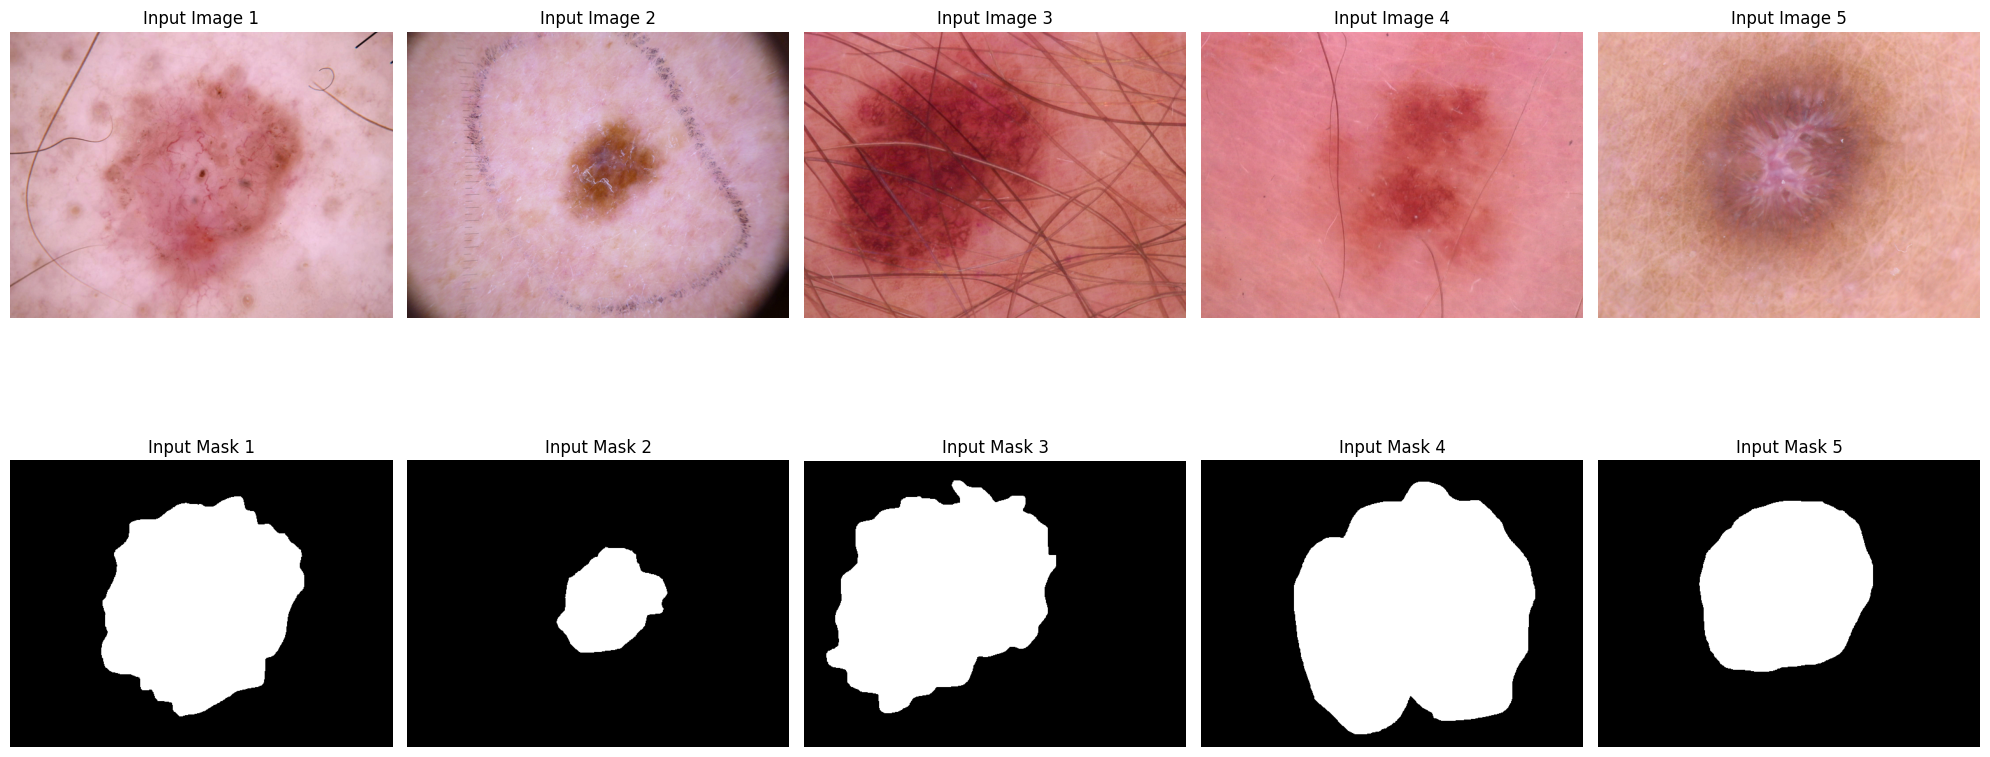

In [6]:
# Path to the dataset directory
dataset_dir = "dataset/"

# Path to the input images and masks directories
input_images_dir = os.path.join(dataset_dir, "input_images/")
input_masks_dir = os.path.join(dataset_dir, "input_images_mask/")

# Get the list of files in the input images directory
input_image_files = os.listdir(input_images_dir)

# Select 5 random image files
random_image_files = random.sample(input_image_files, 5)

# Display the images and masks
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, random_image_file in enumerate(random_image_files):
    # Load and display the input image
    input_image_path = os.path.join(input_images_dir, random_image_file)
    input_image = plt.imread(input_image_path)

    # Load and display the corresponding input mask
    random_mask_file = random_image_file.replace(".jpg", "_segmentation.png")
    input_mask_path = os.path.join(input_masks_dir, random_mask_file)
    input_mask = plt.imread(input_mask_path)

    axes[0, i].imshow(input_image)
    axes[0, i].set_title(f"Input Image {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(input_mask, cmap='gray')
    axes[1, i].set_title(f"Input Mask {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


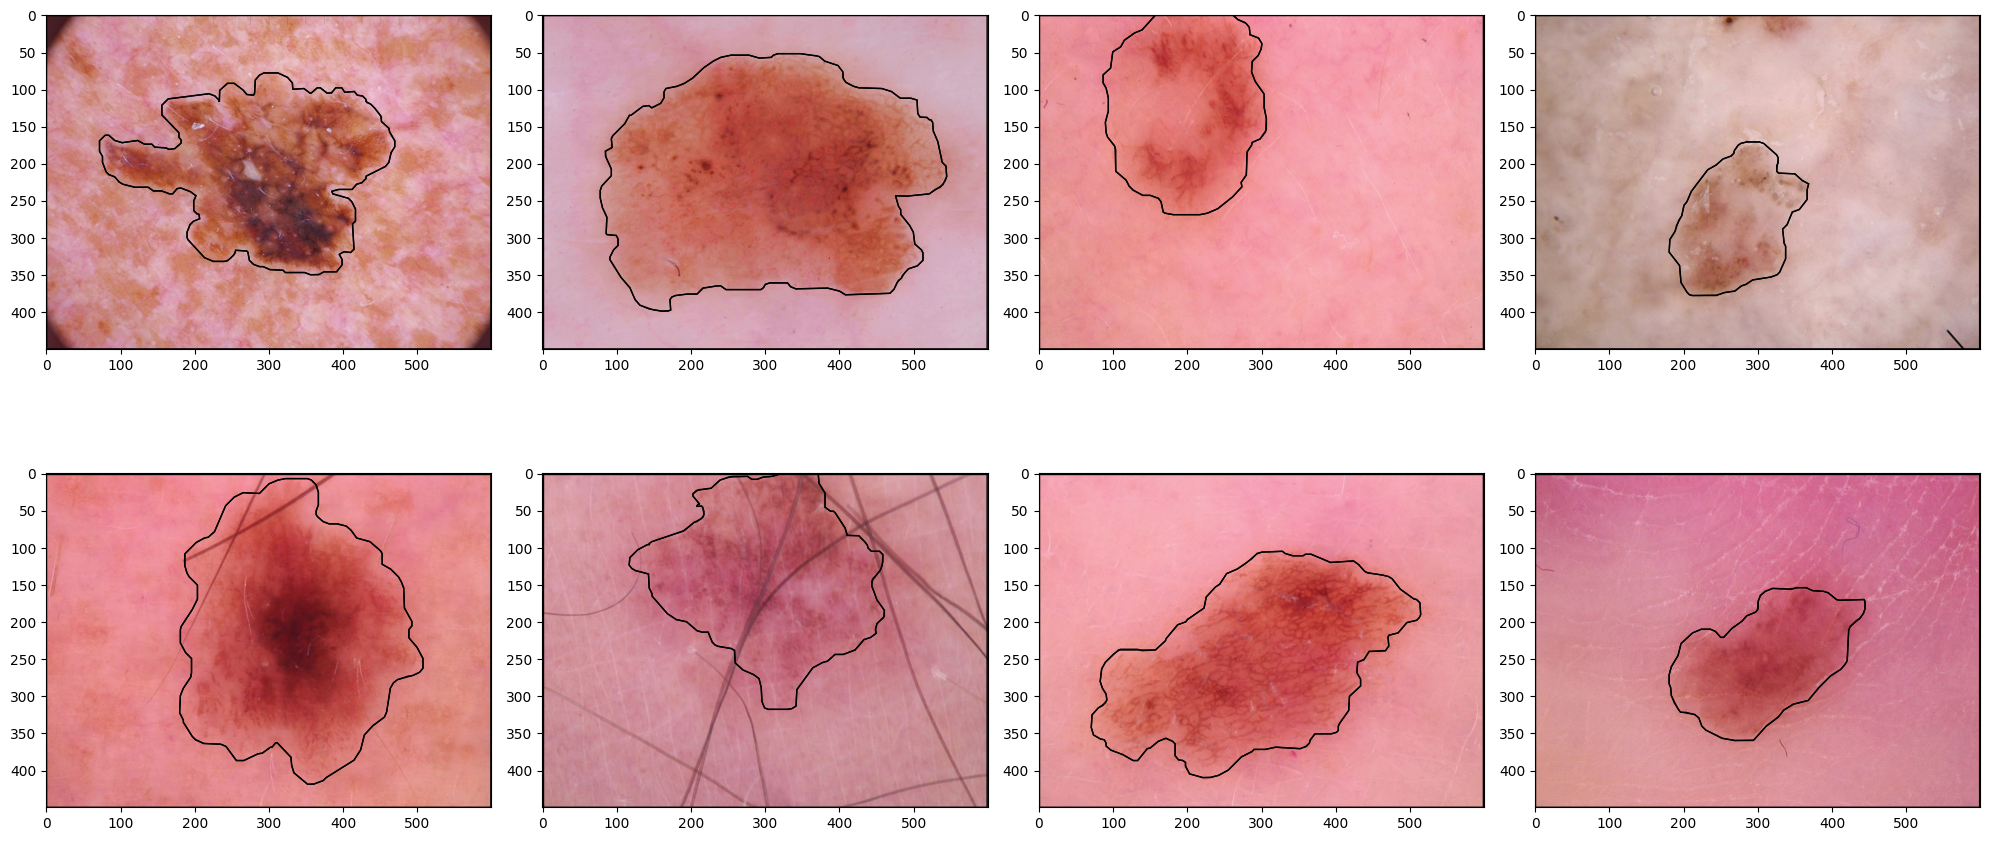

In [7]:
def display_images_with_coco_annotations(image_paths, annotations, display_type='both', colors=None):
    # Create a 2x4 grid of subplots for displaying images
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    
    for ax_row, row_images in zip(axs, image_paths):
       
        for ax, img_path in zip(ax_row, row_images):
           
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            ax.imshow(image)
            ax.axis('on')

            # Find the image ID for the current image path
            img_filename = os.path.basename(img_path)
            img_id = next(item['id'] for item in annotations['images'] if item["file_name"] == img_filename)
            
            # Get the annotations for the current image ID
            img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]
            
            # Iterate over each annotation and display bounding boxes or segmentations
            for ann in img_annotations:
                if display_type in ['bbox', 'both']:
                    bbox = ann['bbox']
                    ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='black', facecolor='none'))
                
                if display_type in ['seg', 'both']:
                    for seg in ann['segmentation']:
                        poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                        ax.add_patch(patches.Polygon(poly, closed=True, edgecolor='black', fill=False))
                        
    plt.tight_layout()
    plt.show()

# Load annotations from the JSON file
with open('dataset/output/input_images.json', 'r') as f:
    annotations = json.load(f)

# Select 8 random image files
image_dir = "dataset/input_images/"
image_files = random.sample([os.path.join(image_dir, img['file_name']) for img in annotations['images']], 8)

# Reshape the list of image files into a 2x4 grid
image_files = [image_files[i:i+4] for i in range(0, len(image_files), 4)]

# Display images with COCO annotations
display_images_with_coco_annotations(image_files, annotations, 'seg')


In [8]:


source_dir = 'dataset\input_images'
output_dir = 'Yolov5_dataset/'
train_dir = 'Yolov5_dataset/train/'
test_dir = 'Yolov5_dataset/test/'
val_dir = 'Yolov5_dataset/val/'

split_percentage_train = 0.8
split_percentage_test = 0.1

# Create output, train, test, and val directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get a list of all the image files
files = os.listdir(source_dir)
random.seed(123)  # Set a fixed random seed
random.shuffle(files)  # Shuffle the files for random splitting

# Calculate the number of files for each split
num_train = int(len(files) * split_percentage_train)
num_test = int(len(files) * split_percentage_test)
num_val = len(files) - num_train - num_test

# Split the files into train, test, and val sets
train_files = files[:num_train]
test_files = files[num_train:num_train + num_test]
val_files = files[num_train + num_test:]

# Copy files to the respective directories
for file in train_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))
for file in test_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))
for file in val_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(val_dir, file))


In [9]:
def coco_to_yolo(coco_annotation_path, output_dir):
    with open(coco_annotation_path, 'r') as f:
        coco_annotations = json.load(f)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    for image_info in coco_annotations['images']:
        img_id = image_info['id']
        img_name = image_info['file_name']
        img_annotations = [ann for ann in coco_annotations['annotations'] if ann['image_id'] == img_id]

        yolo_annotations = []
        for ann in img_annotations:
            bbox = ann['bbox']
            x_center = bbox[0] + bbox[2] / 2
            y_center = bbox[1] + bbox[3] / 2
            width = bbox[2]
            height = bbox[3]

            yolo_annotations.append(f"{ann['category_id']} {x_center} {y_center} {width} {height}")

        with open(os.path.join(output_dir, os.path.splitext(img_name)[0] + '.txt'), 'w') as f:
            f.write('\n'.join(yolo_annotations))

coco_annotation_path = 'dataset\output\input_images.json'
output_dir = 'Yolov5_dataset/yolo'
coco_to_yolo(coco_annotation_path, output_dir)


In [10]:


model = torch.hub.load('ultralytics/yolov5', 'yolov5l', pretrained=True)
# Path to the directory containing train, test, and val folders
data_dir = "Yolov5_dataset/"

# Perform inference on each set (train, test, val)
for set_name in ['train', 'test', 'val']:
    image_dir = Path(data_dir) / set_name
    annotation_dir = Path(data_dir) / 'yolo' / set_name

    # List of image files
    image_files = [file for file in image_dir.rglob('*.jpg')]

    # Perform inference on each image
    for image_file in image_files:
        # Load image
        img = Image.open(image_file)

        # Get corresponding annotation file
        annotation_file = annotation_dir / (image_file.stem + '.txt')

        # Perform inference
        results = model(img)
    
        # Process results (e.g., apply masking using annotations)
        


Using cache found in C:\Users\SUVROJIT/.cache\torch\hub\ultralytics_yolov5_master


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'setuptools>=65.5.1'] not found, attempting AutoUpdate...
   ---------------------------------------- 195.4/195.4 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 819.3/819.3 kB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 62.7/62.7 kB ? eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.5.0
    Uninstalling setuptools-65.5.0:
      Successfully uninstalled setuptools-65.5.0

requirements: AutoUpdate success ✅ 17.4s, installed 2 packages: ['gitpython>=3.1.30', 'setuptools>=65.5.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5  2024-2-21 Python-3.11.8 torch-2.2.0+cpu CPU

100.0%

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients, 109.0 GFLOPs
Adding AutoShape... 


In [11]:
results.print()

image 1/1: 450x600 (no detections)
Speed: 9.2ms pre-process, 771.7ms inference, 1.0ms NMS per image at shape (1, 3, 480, 640)


In [12]:
data_dir = "Yolov5_dataset/"
image_dir = Path(data_dir)
annotation_dir = Path(data_dir) / 'yolo'


In [14]:
def infer_and_plot(image_file, set_name):
    """
    Performs inference on an image and plots the predictions.

    Args:
        image_file (Path): Path to the image file.
        set_name (str): Name of the image set (train, test, or val).
    """

    # Load image
    img = Image.open(image_file)

    # Perform inference
    results = model(img)

    # Extract predicted bounding boxes and labels
    boxes = results.pandas().xyxy[0]  # Assuming single image inference and batch size 1

    # Convert bounding boxes to NumPy array for easier manipulation
    boxes_np = boxes[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()

    # Create a copy of the image for visualization
    img_copy = np.array(img)

    # Draw bounding boxes on the image copy
    for box in boxes_np:
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(img_copy, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)

    # Display the image with predictions
    plt.figure(figsize=(10, 6))
    plt.imshow(img_copy)
    plt.title(f"Predictions on {set_name} image: {image_file.name}")
    plt.axis('off')
    plt.show()
    plt.close() 

for set_name in ['train', 'test', 'val']:
    image_dir_set = image_dir / set_name

    # List image files in the current set
    image_files = [file for file in image_dir_set.rglob('*.jpg')]

    # Process each image and plot predictions
    for image_file in image_files:
        infer_and_plot(image_file, set_name)    


In [ ]:
for set_name in ['train', 'test', 'val']:
    image_dir_set = image_dir / set_name

    # List image files in the current set
    image_files = [file for file in image_dir_set.rglob('*.jpg')]

    # Process each image and plot predictions
    for image_file in image_files:
        infer_and_plot(image_file, set_name)
